# Imports and Setup

In [ ]:
!curl https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release | tar xz
%cd sqlite/
!./configure
!make sqlite3.c
%cd /content
!npx degit coleifer/pysqlite3 -f
!cp sqlite/sqlite3.[ch] .
!python setup.py build_static build
!cp build/lib.linux-x86_64-3.7/pysqlite3/_sqlite3.cpython-37m-x86_64-linux-gnu.so \
     /usr/lib/python3.7/lib-dynload/
# then: Runtime > Restart runtime ...

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#email: mids.w210.fcm@gmail.com
#pass: fostercarematching

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pickle

from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor, plot_tree


import statsmodels.api as sm
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def one_hot(df, field_to_encode, dummy_na=False):

    # Get one hot encoding of columns
    HOT_ENCODINGS = pd.get_dummies(df[field_to_encode], prefix=field_to_encode, dummy_na=dummy_na)

    # Drop categorical column as it is now encoded
    # df = df.drop(field_to_encode,axis = 1)

    # Join the encoded df
    df = df.join(HOT_ENCODINGS)

    return df

In [4]:
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 500)

In [5]:
# filepath_2019 = "/content/gdrive/My Drive/Data/FC_2019/Data/Text/FC2019v1.tab"
# filepath_2018 = "/content/gdrive/My Drive/Data/FC_2018/DATA/Text Files/FC2018v2.tab"
# filepath_2017 = "/content/gdrive/My Drive/Data/FC_2017/Data/Text Files/FC2017v4.tab"
# filepath_2016 = "/content/gdrive/My Drive/Data/FC_2016/Data/Text Files/FC2016v3.tab"
# filepath_2015 = "/content/gdrive/My Drive/Data/FC_2015/Data/Text Files/FC2015v5.tab"
# filepath_all = "/content/gdrive/My Drive/Data/MASTER_FILE.csv"
# filepath_placement_hist = "/content/gdrive/My Drive/Data/Removal_Placement_History.csv"
filepath_demographics = "/content/gdrive/My Drive/Data/Demographics.csv"
filepath_FLall = "/content/gdrive/My Drive/Data/fldata.tab"
# filepath_annotated = "/content/gdrive/My Drive/Data/annotated_RPH_July2020.csv"
# field_headers = "/content/gdrive/My Drive/Data/Field_Headers.csv"
historical = "/content/gdrive/My Drive/Data/RPH_PLACEMENT_LEVEL_HISTORICAL_FEATURES_ANNOTATED.csv"

In [6]:
# %%time
FLafcardsdf = pd.read_table(filepath_FLall, low_memory=False)
# FLplacementsdf = pd.read_csv(filepath_placement_hist, encoding = "ISO-8859-1", low_memory=False)
# FLplacementsdf_Annotated = pd.read_csv(filepath_annotated, low_memory=False)
FLDemographicsdf = pd.read_csv(filepath_demographics, low_memory=False)

In [7]:
HISTORICAL = pd.read_csv(historical, low_memory=False)

# Load Dataset

In [233]:
MASTER = pd.read_csv("/content/gdrive/My Drive/Data/REGRESSION_DATASET.csv", low_memory=False)

In [234]:
# MASTER['PROVIDER_NUM_PREV_PLACEMENTS'].head()

In [235]:
MASTER = MASTER[MASTER['PLACEMENT_DURATION'] >= 1]

In [236]:
MASTER = MASTER[MASTER['PROVIDER_NUM_PREV_PLACEMENTS'] >= 1]

In [237]:
MASTER.rename(columns = lambda x: x.replace(' ', '_').upper(), inplace=True)

In [238]:
MASTER['PLACEMENT_BEGIN_V2'] = pd.to_datetime(MASTER['PLACEMENT_BEGIN_V2'])

In [239]:
# MASTER['PLACEMENT_DURATION_DECILE'] = pd.qcut(MASTER['PLACEMENT_DURATION'], 20, labels=False)

In [240]:
# MASTER.groupby('PLACEMENT_DURATION_DECILE')['AFCARS_ID'].count()

In [241]:
max(MASTER.groupby(['AFCARS_ID','PLACEMENT_BEGIN_V2'])['AFCARS_ID'].count())

1

In [242]:
MASTER.loc[(MASTER['CHILD_NUM_PREV_PLACEMENTS'] == 0), 'CHILD_NUM_PREV_PLACEMENTS_GOOD'] = np.nan
MASTER.loc[(MASTER['CHILD_NUM_PREV_PLACEMENTS'] == 0), 'CHILD_NUM_PREV_PLACEMENTS_NEUTRAL'] = np.nan
MASTER.loc[(MASTER['CHILD_NUM_PREV_PLACEMENTS'] == 0), 'CHILD_NUM_PREV_PLACEMENTS_BAD'] = np.nan
MASTER.loc[(MASTER['CHILD_NUM_PREV_PLACEMENTS'] == 0), 'CHILD_PREV_PLACEMENT_OUTCOME'] = np.nan
MASTER.loc[(MASTER['CHILD_NUM_PREV_PLACEMENTS'] == 0), 'CHILD_DAYS_SINCE_FIRST_PLACEMENT'] = np.nan
MASTER.loc[(MASTER['CHILD_NUM_PREV_PLACEMENTS'] == 0), 'CHILD_NUM_PREV_PLACEMENTS_GOOD_PERC'] = np.nan
MASTER.loc[(MASTER['CHILD_NUM_PREV_PLACEMENTS'] == 0), 'CHILD_NUM_PREV_PLACEMENTS_NEUTRAL_PERC'] = np.nan
MASTER.loc[(MASTER['CHILD_NUM_PREV_PLACEMENTS'] == 0), 'CHILD_NUM_PREV_PLACEMENTS_BAD_PERC'] = np.nan


# MASTER.loc[(MASTER['PROVIDER_NUM_PREV_PLACEMENTS'] == 0), 'PROVIDER_NUM_PREV_PLACEMENTS_GOOD'] = np.nan
# MASTER.loc[(MASTER['PROVIDER_NUM_PREV_PLACEMENTS'] == 0), 'PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL'] = np.nan
# MASTER.loc[(MASTER['PROVIDER_NUM_PREV_PLACEMENTS'] == 0), 'PROVIDER_NUM_PREV_PLACEMENTS_BAD'] = np.nan
# MASTER.loc[(MASTER['PROVIDER_NUM_PREV_PLACEMENTS'] == 0), 'PROVIDER_PREV_PLACEMENT_OUTCOME'] = np.nan
# MASTER.loc[(MASTER['PROVIDER_NUM_PREV_PLACEMENTS'] == 0), 'PROVIDER_DAYS_SINCE_FIRST_PLACEMENT'] = np.nan
# MASTER.loc[(MASTER['PROVIDER_NUM_PREV_PLACEMENTS'] == 0), 'PROVIDER_NUM_PREV_PLACEMENTS_GOOD_PERC'] = np.nan
# MASTER.loc[(MASTER['PROVIDER_NUM_PREV_PLACEMENTS'] == 0), 'PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL_PERC'] = np.nan
# MASTER.loc[(MASTER['PROVIDER_NUM_PREV_PLACEMENTS'] == 0), 'PROVIDER_NUM_PREV_PLACEMENTS_BAD_PERC'] = np.nan

In [243]:
MASTER = one_hot(MASTER, 'CHILD_PREV_PLACEMENT_OUTCOME', dummy_na=True)
MASTER = one_hot(MASTER, 'PROVIDER_PREV_PLACEMENT_OUTCOME', dummy_na=False)

In [244]:
GOOD_OUTCOMES = ['Reunification w/Parent(s) including Non-',
              'Adoption Finalization',
              'Permanent Guardianship (Includes Guardia',
              'Placement with a fit and willing Relativ',
              'Child ages out (18 - 23 Years Old)',
              'Adoption Placement',
              'Reunited with Removal Home Caregiver-Not',
              'APPLA (Another Planned Permanent Living',
              'Voluntary Opt Out (EFC only)',
              'Child Ages Out Non-EFC',
              'Young Adult Ages Out (EFC only)',
              'Permanent Guardianship to Successor Guar',
              'Child Ages Out (18 - 23 Years Old)',
              'Entered Military Service']

NEUTRAL_OUTCOMES = ['Move Made in Accordance with Case Plan G',
              '(null)',
              'Dismissed by Court',
              'Transfer to Other Agency (i.e. Out of Co',
              'Emancipation',
              'Duplicate',
              'No Longer EFC Eligible',
              'Other',
              'Birthday Batch',
              'Marriage',
              'Duplicate Provider Clean-up',
              'Trial Home Visit from Court-Ordered Plcm']

BAD_OUTCOMES = ['Provider Requested Change',
              'Runaway - NOT Closing Case',
              'Parent/Relative/Guardian Requested Chang',
              'Incarceration/Detention',
              'Hospitalization (more than 30 days)',
              'Child Requested Change',
              'Runaway - Closing Case',
              'Placement Overcapacity',
              'Provider No Longer Licensed',
              'Change in EFC Supervised IL Arrangement/',
              'Adoption Disruption',
              'Child in Correctional Facility W/Afterca',
              'Death of Child',
              'Entering EFC Supervised IL Arrangement/P',
              'Absconded',
              'Abducted',
              'Placement Disruption']              



MASTER['PLACEMENT_END_REASON_BIN'] = 'N/A'
MASTER.loc[MASTER['PLACEMENT_END_REASON'].isin(GOOD_OUTCOMES), 'PLACEMENT_END_REASON_BIN'] = 'GOOD OUTCOME'
MASTER.loc[MASTER['PLACEMENT_END_REASON'].str.contains('APPLA'), 'PLACEMENT_END_REASON_BIN'] = 'GOOD OUTCOME'
MASTER.loc[(MASTER['PLACEMENT_END_REASON'].isin(NEUTRAL_OUTCOMES)) | (MASTER['PLACEMENT_END_REASON'].isnull()), 'PLACEMENT_END_REASON_BIN'] = 'NEUTRAL OUTCOME'
MASTER.loc[MASTER['PLACEMENT_END_REASON'].isin(BAD_OUTCOMES), 'PLACEMENT_END_REASON_BIN'] = 'BAD OUTCOME'

In [245]:
for i in sorted(MASTER['PLACEMENT_END_REASON'].unique()):
    print(i)

APPLA (Another Planned Permanent Living 
Abducted
Absconded
Adoption Disruption
Adoption Finalization
Adoption Placement
Birthday Batch
Change in EFC Supervised IL Arrangement/
Child Ages Out Non-EFC
Child Requested Change
Child ages out (18 - 23 Years Old)
Child in Correctional Facility W/Afterca
Death of Child
Dismissed by Court
Duplicate
Duplicate Provider Clean-up
Emancipation
Entered Military Service
Entering EFC Supervised IL Arrangement/P
Hospitalization (more than 30 days)
Incarceration/Detention
Marriage
Move Made in Accordance with Case Plan G
No Longer EFC Eligible
Other
Parent/Relative/Guardian Requested Chang
Permanent Guardianship (Includes Guardia
Permanent Guardianship to Successor Guar
Placement Disruption
Placement Overcapacity
Placement with a fit and willing Relativ
Provider No Longer Licensed
Provider Requested Change
Reunification w/Parent(s) including Non-
Reunited with Removal Home Caregiver-Not
Runaway - Closing Case
Runaway - NOT Closing Case
Transfer to Other

In [246]:
MASTER['PLACEMENT_END_REASON_V2'] = MASTER['PLACEMENT_END_REASON']
MASTER.loc[MASTER['PLACEMENT_END_REASON'].isin(['Permanent Guardianship (Includes Guardia','Permanent Guardianship to Successor Guar']), 'PLACEMENT_END_REASON_V2'] = 'Permanent Guardianship'
MASTER.loc[MASTER['PLACEMENT_END_REASON'].isin(['Child Ages Out (18 - 23 Years Old)','Child ages out (18 - 23 Years Old)']), 'PLACEMENT_END_REASON_V2'] = 'Child ages out (18 - 23 Years Old)'
MASTER.loc[MASTER['PLACEMENT_END_REASON'].isin(['Runaway - Closing Case','Runaway - NOT Closing Case']), 'PLACEMENT_END_REASON_V2'] = 'Runaway'
MASTER.loc[MASTER['PLACEMENT_END_REASON'].isin(['Reunification w/Parent(s) including Non-','Reunited with Removal Home Caregiver-Not']), 'PLACEMENT_END_REASON_V2'] = 'Reunification'
MASTER.loc[MASTER['PLACEMENT_END_REASON'].isin(['Duplicate','Duplicate Provider Clean-up']), 'PLACEMENT_END_REASON_V2'] = 'Duplicate'

# Brining In AFCARS

In [247]:
FLafcardsdf = pd.read_table(filepath_FLall, low_memory=False)

In [248]:
# Replacing "Unknown" Values with NaN so it is complementary with records where we don't know these values because we couldn't join to the placement record

# ‘‘Unable to Determine’’ (3): the child has been abandoned or the child’s parent(s) are otherwise not available to provide the information.
FLafcardsdf['EVERADPT'].replace(3, np.nan, inplace=True)

# “Unable to Determine” (5): the child has been abandoned or the child’s caretakers are otherwise unknown.
FLafcardsdf['CTKFAMST'].replace(5, np.nan, inplace=True)

# Case Plan Goal Not Yet Established (7) — No case plan goal has yet been established other than the care and protection of the child.
# FLafcardsdf['CASEGOAL'].replace(7, np.nan, inplace=True)

# “Unable to Determine” (5): No Description but there is an option for Not Applicable which reflects a specific situation
FLafcardsdf['AGEADOPT'].replace(5, np.nan, inplace=True)

# FLafcardsdf['EVERADPT'].fillna(3, inplace=True)
# FLafcardsdf['CTKFAMST'].fillna(5, inplace=True)

In [249]:
FLafcardsdf.rename(columns = lambda x: x.replace(' ', '_').upper(), inplace=True)

In [250]:
FLafcardsdf['RECNUMBRINT'] = FLafcardsdf['RECNUMBR'].astype(int)

In [251]:
#select actual DOB from demograhics file (in afcars, it is rounded to 15th of the month)
FLDOBdf = FLDemographicsdf[['ID_PRSN_ENCRYPTED','DT_BRTH']]
#Merge into afcars 
FLAfcardsWithActualDOB = pd.merge(FLafcardsdf, FLDOBdf, left_on = 'RECNUMBRINT', right_on = 'ID_PRSN_ENCRYPTED', how = 'left')

In [252]:
#FLAfcardsWithActualDOB
#replace nulls with values 
FLAfcardsWithActualDOB["DT_BRTH"].fillna("1900-01-01", inplace = True)
#replace '(null)' with 1900-01-01
FLAfcardsWithActualDOB.loc[FLAfcardsWithActualDOB['DT_BRTH'] == '(null)', 'DT_BRTH'] = '1900-01-01'

In [253]:

#FLAfcardsWithActualDOB[FLAfcardsWithActualDOB['DT_BRTH'] == '(null)'].count()
#pd.to_datetime(FLAfcardsWithActualDOB['DT_BRTH'])

FLAfcardsWithActualDOB['DOBDiff'] = (pd.to_datetime(FLAfcardsWithActualDOB['DT_BRTH']) - pd.to_datetime(FLAfcardsWithActualDOB['DOB'])).dt.days

# FLAfcardsWithActualDOB.groupby(['DOBDiff'])['RecNumbrInt'].count().sort_values(ascending=False)

In [254]:
#one time to get the actual placement date
FLAfcardsWithActualDOB['ActualPlacementDate'] = (pd.to_datetime(FLAfcardsWithActualDOB['CURSETDT']) + pd.to_timedelta(FLAfcardsWithActualDOB['DOBDiff'],unit = 'd'))

In [255]:
FLAfcardsWithActualDOB['CARETAKER_AGE'] = pd.DatetimeIndex(FLAfcardsWithActualDOB['ActualPlacementDate']).year - FLAfcardsWithActualDOB['CTK1YR']
FLAfcardsWithActualDOB['FOSTER_AGE'] = pd.DatetimeIndex(FLAfcardsWithActualDOB['ActualPlacementDate']).year - FLAfcardsWithActualDOB['FCCTK1YR']

In [256]:
# FLAfcardsWithActualDOB['AVERAGE_CTK_AGE_AT_PLACEMENT'] = (pd.DatetimeIndex(FLAfcardsWithActualDOB['ActualPlacementDate']).year - FLAfcardsWithActualDOB['CTK1YR'] + \
#                                                           pd.DatetimeIndex(FLAfcardsWithActualDOB['ActualPlacementDate']).year - FLAfcardsWithActualDOB['CTK2YR']) / \
#                                                           2

In [257]:
FLAfcardsWithActualDOB.head()

,FY,VERSION,STATE,ST,REPDATYR,REPDATMO,FIPSCODE,RECNUMBR,SEX,AMIAKN,ASIAN,BLKAFRAM,HAWAIIPI,WHITE,UNTODETM,HISORGIN,CLINDIS,MR,VISHEAR,PHYDIS,EMOTDIST,OTHERMED,EVERADPT,AGEADOPT,TOTALREM,NUMPLEP,MANREM,PHYABUSE,SEXABUSE,NEGLECT,AAPARENT,DAPARENT,AACHILD,DACHILD,CHILDIS,CHBEHPRB,PRTSDIED,PRTSJAIL,NOCOPE,ABANDMNT,RELINQSH,HOUSING,CURPLSET,PLACEOUT,CASEGOAL,CTKFAMST,CTK1YR,CTK2YR,FOSFAMST,FCCTK1YR,FCCTK2YR,RF1AMAKN,RF1ASIAN,RF1BLKAA,RF1NHOPI,RF1WHITE,RF1UTOD,HOFCCTK1,RF2AMAKN,RF2ASIAN,RF2BLKAA,RF2NHOPI,RF2WHITE,RF2UTOD,HOFCCTK2,DISREASN,IVEFC,IVEAA,IVAAFDC,IVDCHSUP,XIXMEDCD,SSIOTHER,NOA,FCMNTPAY,DOB,PEDREVDT,REM1DT,REMTRNDT,DLSTFCDT,LATREMDT,CURSETDT,DODFCDT,DODTRNDT,TPRMOMDT,TPRDADDT,TPRDATE,LATREMLOS,SETTINGLOS,PREVIOUSLOS,LIFELOS,AGEATSTART,AGEATLATREM,AGEATEND,INATSTART,INATEND,ENTERED,EXITED,SERVED,ISWAITING,ISTPR,AGEDOUT,RACEETHN,RACE,RU13,STFCID,RECNUMBRINT,ID_PRSN_ENCRYPTED,DT_BRTH,DOBDiff,ActualPlacementDate,CARETAKER_AGE,FOSTER_AGE
0,2010,6,12,FL,2010,9,12011.0,51010189,2.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2.0,1,2.0,1988.0,1985.0,3.0,1964.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2006-04-15,2010-07-31,2009-08-04,2010-05-03,2010-03-20,2010-04-06,2010-04-06,NaN,NaN,NaN,NaN,NaN,168.0,168.0,228.0,396.0,3,3,4,0,1,1,0,1,0,0,0,2,2,1.0,FL000051010189,51010189,51010189.0,2006-04-24,9.0,2010-04-15,22.0,46.0
1,2010,6,12,FL,2010,3,12099.0,91010109,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2.0,1,2.0,1984.0,1979.0,3.0,1954.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2004-04-15,NaN,2009-05-21,2009-07-13,NaN,2009-05-21,2009-05-21,2009-12-22,2010-01-26,NaN,NaN,NaN,215.0,215.0,NaN,215.0,5,5,5,1,0,0,1,1,0,0,0,99,99,1.0,FL000091010109,91010109,91010109.0,2004-04-17,2.0,2009-05-23,25.0,55.0
2,2010,6,12,FL,2010,9,12095.0,111010119,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,1.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2.0,3,3.0,1970.0,NaN,3.0,1924.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,435.0,2009-06-15,2010-08-31,2009-10-22,2009-11-05,NaN,2009-10-22,2010-06-01,NaN,NaN,NaN,NaN,NaN,342.0,120.0,NaN,342.0,0,0,1,0,1,1,0,1,1,0,0,1,1,1.0,FL000111010119,111010119,111010119.0,2009-06-16,1.0,2010-06-02,40.0,86.0
3,2010,6,12,FL,2010,3,8.0,121010199,2.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,1.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2.0,1,2.0,1981.0,1981.0,0.0,1955.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2009-01-15,2009-10-17,2009-06-18,2009-06-20,NaN,2009-06-18,2009-06-18,2009-10-17,2009-11-25,NaN,NaN,NaN,121.0,121.0,NaN,121.0,0,0,0,1,0,0,1,1,0,0,0,1,1,2.0,FL000121010199,121010199,121010199.0,2009-01-14,-1.0,2009-06-17,28.0,54.0
4,2010,6,12,FL,2010,3,8.0,126152401,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,3.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2.0,2,2.0,1978.0,1976.0,1.0,1945.0,1939.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2001-06-15,2009-12-04,2001-10-06,2008-08-02,2005-08-26,2008-06-21,2009-05-12,2009-12-04,2010-01-01,NaN,NaN,NaN,531.0,206.0,NaN,NaN,8,7,8,1,0,0,1,1,0,0,0,1,1,3.0,FL000126152401,126152401,126152401.0,2001-06-12,-3.0,2009-05-09,31.0,64.0


In [258]:
# One-Hot Encode Casegoal
FLAfcardsWithActualDOB = one_hot(FLAfcardsWithActualDOB, 'CASEGOAL')

In [259]:
# One-Hot Encode Ever Adopted
FLAfcardsWithActualDOB = one_hot(FLAfcardsWithActualDOB, 'EVERADPT')

In [260]:
# One-Hot Encode Ever Adopted
FLAfcardsWithActualDOB = one_hot(FLAfcardsWithActualDOB, 'AGEADOPT')

In [261]:
# One-Hot Encode Family Caretaker Structure
FLAfcardsWithActualDOB = one_hot(FLAfcardsWithActualDOB, 'CTKFAMST') 

In [262]:
# One-Hot Encode Foster Structure
FLAfcardsWithActualDOB = one_hot(FLAfcardsWithActualDOB, 'FOSFAMST')  

In [263]:
# for i in ['RF1AMAKN'
#         ,'RF1ASIAN'
#         ,'RF1BLKAA'
#         ,'RF1NHOPI'
#         ,'RF1WHITE'
#         ,'RF1UTOD'
#         ,'HOFCCTK1']:
#     print(i, FLAfcardsWithActualDOB[i].unique())


In [264]:
FLAfcardsWithActualDOB['ROW_NUM'] = FLAfcardsWithActualDOB.sort_values('FY', ascending=False).groupby(['RECNUMBR','ActualPlacementDate']).cumcount()+1
FLAfcardsWithActualDOB = FLAfcardsWithActualDOB[FLAfcardsWithActualDOB['ROW_NUM'] == 1]

In [265]:
PLACEMENT_W_AFCARS = pd.merge(MASTER, FLAfcardsWithActualDOB, left_on=['AFCARS_ID','PLACEMENT_BEGIN_V2'], right_on=['RECNUMBR','ActualPlacementDate'], how='left')

In [266]:
len(PLACEMENT_W_AFCARS)

814016

In [359]:
PLACEMENT_W_AFCARS.sample(10)

,AFCARS_ID,PLACEMENT_BEGIN,PLACEMENT_END_X,PLACEMENT_END_REASON,PROVIDER_ID,PROVIDER_NAME,ROW_N_PROVIDER,ROW_N,AFCARS_ID:1,REMOVAL_DATE,PLACEMENT_BEGIN_DATE,PLACEMENT_END_DATE,PLACEMENT_END_REASON:1,SERVICE_CATEGORY,SERVICE_TYPE,LEAD_AGENCY,PROVIDER_NAME:1,PROVIDER_ID:1,PROVIDER_ZIP,RELATION_TO_CAREGIVER,DISCHARGE_DATE,DISCHARGE_REASON,PHYSICAL_ABUSE,SEXUAL_ABUSE,EMOTIONAL_ABUSE_NEGLECT,ALCOHOL_ABUSE_CHILD,DRUG_ABUSE_CHILD,ALCOHOL_ABUSE_PARENT,DRUG_ABUSE_PARENT,PHYSICAL_NEGLECT,DOMESTIC_VIOLENCE,INADEQUATE_HOUSING,CHILD_BEHAVIOR_PROBLEM,CHILD_DISABILITY,INCARCERATION_OF_PARENT,DEATH_OF_PARENT,CAREGIVER_INABILITY_TO_COPE,ABANDONMENT,TRANSITION_TO_INDEPENDENCE,INADEQUATE_SUPERVISION,PROSPECTIVE_EMOTIONAL_ABUSE_NEGLECT,PROSPECTIVE_MEDICAL_NEGLECT,PROSPECTIVE_PHYSICAL_ABUSE,PROSPECTIVE_PHYSICAL_NEGLECT,PROSPECTIVE_SEXUAL_ABUSE,RELINQUISHMENT,REQUEST_FOR_SERVICE,ADOPTION_DISSOLUTION,MEDICAL_NEGLECT,CSEC,LABOR_TRAFFICKING,SEXUAL_ABUSE_SEXUAL_EXPLOITATION,REMOVAL_DATE_CLEAN,PLACEMENT_BEGIN_DATE_CLEAN,PLACEMENT_END_DATE_CLEAN,DISCHARGE_DATE_CLEAN,PROVIDER_NAME_CONFIDENTIAL,PLACEMENT_LENGTH,REMOVAL_LENGTH,PLACEMENT_ENDED,REMOVAL_ENDED,PLACEMENT_NUMBER,IS_ADMIN_ENTRY,PLACEMENT_NUMBER_NO_ADMIN,NEW_REMOVAL,PROVIDER_PLACEMENT_NUMBER,PROVIDER_CAPACITY_COUNT,ZIP5,LATITUDE,LONGITUDE,MOVE_MILES,PLACEMENT_COUNTY,PLACEMENT_STATE,PLACEMENT_REGION,PLACEMENT_CBC,PLACEMENT_CIRCUIT,PROVIDER_CHILD_NUMBER,ROOMMATE_COUNT,MALTREATMENT_COUNT,CITIZENSHIP,GENDER,DOB_x,PRIMARY_LANGUAGE,RACE_WHITE,RACE_BLACK,RACE_ASIAN,RACE_UNKNOWN,RACE_HAWAIIAN,RACE_AMERICAN_INDIAN,RACE_MULTI_RCL,INDIAN_TRIBE,HISPANIC,RACE_LABEL_SIMPLE,AGE_AT_REMOVAL,AGE_AT_PLACEMENT_BEGIN,AGE_AT_PLACEMENT_END,AGE_AT_DISCHARGE,PLACEMENT_SIMPLE_TYPE,LAST_PLACEMENT_SETTING,DISCHARGE_CATEGORY,PROVIDER_FLAGS,ERROR_REMOVAL_DATE_MISORDER,PRIMARY_LEAD_AGENCY,MALTREATMENT_CATEGORY,IS_LAST_PLACEMENT,IS_LAST_PLACEMENT_UNDER_18,NEXT_PLACEMENT_BEGIN,NEXT_PLACEMENT_END,NEXT_ROW_N_PROVIDER,NEXT_ROW_N,PREV_ROW_N,PREV_PROVIDER_ID,TIMES_PROVIDER_SEEN,ROW_SESSION,ROW_SESSION_REV,PLACEMENT_BEGIN_V2,PLACEMENT_(NULL),PLACEMENT_FOSTER_FAMILY_HOME_(NON-RELATIVE),PLACEMENT_FOSTER_FAMILY_HOME_(RELATIVE),PLACEMENT_GROUP_HOME,PLACEMENT_INSTITUTION,PLACEMENT_PRE-ADOPTIVE_HOME,PLACEMENT_RUNAWAY,PLACEMENT_SUPERVISED_INDEPENDENT_LIVING,PLACEMENT_TRIAL_HOME_VISIT,PLACEMENT_DURATION,ROW_NUM_X,PLACEMENT_END_Y,CHILD_NUM_PREV_PLACEMENTS,CHILD_NUM_PREV_PLACEMENTS_GOOD,CHILD_NUM_PREV_PLACEMENTS_NEUTRAL,CHILD_NUM_PREV_PLACEMENTS_BAD,CHILD_PREV_PLACEMENT_OUTCOME,CHILD_DAYS_SINCE_FIRST_PLACEMENT,PROVIDER_NUM_PREV_PLACEMENTS,PROVIDER_NUM_PREV_PLACEMENTS_GOOD,PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL,PROVIDER_NUM_PREV_PLACEMENTS_BAD,PROVIDER_PREV_PLACEMENT_OUTCOME,PROVIDER_DAYS_SINCE_FIRST_PLACEMENT,CHILD_NUM_PREV_PLACEMENTS_GOOD_PERC,CHILD_NUM_PREV_PLACEMENTS_NEUTRAL_PERC,CHILD_NUM_PREV_PLACEMENTS_BAD_PERC,PROVIDER_NUM_PREV_PLACEMENTS_GOOD_PERC,PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL_PERC,PROVIDER_NUM_PREV_PLACEMENTS_BAD_PERC,ROW_NUM_Y,PROVIDER_FLAGS_SPLIT,HIGH_DISRUPTION,HIGH_TURNOVER,HIGH_MILEAGE,HIGH_REUNIFICATION,DEATH_OF_CHILD,HIGH_ARREST_RATE,HIGH_BAKER_ACT,HIGH_HOSPITALIZATION,HIGH_RUN,HIGH_OCCUPANCY,HIGH_FIRST_RUN,HIGH_NIGHT_TO_NIGHT,HIGH_ADOPTION,HIGH_AGE_OUT,HIGH_GUARDIANSHIP,CHILD_PREV_PLACEMENT_OUTCOME_1.0,CHILD_PREV_PLACEMENT_OUTCOME_2.0,CHILD_PREV_PLACEMENT_OUTCOME_3.0,CHILD_PREV_PLACEMENT_OUTCOME_nan,PROVIDER_PREV_PLACEMENT_OUTCOME_1.0,PROVIDER_PREV_PLACEMENT_OUTCOME_2.0,PROVIDER_PREV_PLACEMENT_OUTCOME_3.0,PLACEMENT_END_REASON_BIN,PLACEMENT_END_REASON_V2,FY,VERSION,STATE,ST,REPDATYR,REPDATMO,FIPSCODE,RECNUMBR,SEX,AMIAKN,ASIAN,BLKAFRAM,HAWAIIPI,WHITE,UNTODETM,HISORGIN,CLINDIS,MR,VISHEAR,PHYDIS,EMOTDIST,OTHERMED,EVERADPT,AGEADOPT,TOTALREM,NUMPLEP,MANREM,PHYABUSE,SEXABUSE,NEGLECT,AAPARENT,DAPARENT,AACHILD,DACHILD,CHILDIS,CHBEHPRB,PRTSDIED,PRTSJAIL,NOCOPE,ABANDMNT,RELINQSH,HOUSING,CURPLSET,PLACEOUT,CASEGOAL,CTKFAMST,CTK1YR,CTK2YR,FOSFAMST,FCCTK1YR,FCCTK2YR,RF1AMAKN,RF1ASIAN,RF1BLKAA,RF1NHOPI,RF1WHITE,RF1UTOD,HOFCCTK1,RF2AMAKN,RF2

In [267]:
max(PLACEMENT_W_AFCARS.groupby(['AFCARS_ID','PLACEMENT_BEGIN_V2'])['AFCARS_ID'].count())

1

# Compiling Dataset For Modeling

In [393]:
FEATURES = [
                                #  'AFCARS_ID'
                                #  ,'REMOVAL_DATE_CLEAN'
                                #  ,'PLACEMENT_BEGIN_DATE_CLEAN'
                                #  ,'PLACEMENT_END_DATE_CLEAN'
                                #  ,'DISCHARGE_DATE_CLEAN'
                                #  ,'PLACEMENT_SETTING' #One-Hot Encode

                                  #REASONS FOR ENTERING FOSTER CARE SYSTEM
                                 'PHYSICAL_ABUSE'
                                 ,'SEXUAL_ABUSE'                                                           
                                 ,'EMOTIONAL_ABUSE_NEGLECT'
                                 ,'ALCOHOL_ABUSE_CHILD'
                                 ,'DRUG_ABUSE_CHILD'
                                 ,'ALCOHOL_ABUSE_PARENT'
                                 ,'DRUG_ABUSE_PARENT'
                                 ,'PHYSICAL_NEGLECT'
                                 ,'DOMESTIC_VIOLENCE'
                                 ,'INADEQUATE_HOUSING'
                                 ,'CHILD_BEHAVIOR_PROBLEM'
                                 ,'CHILD_DISABILITY'
                                 ,'INCARCERATION_OF_PARENT'
                                 ,'DEATH_OF_PARENT'
                                 ,'CAREGIVER_INABILITY_TO_COPE'
                                 ,'ABANDONMENT'
                                 ,'TRANSITION_TO_INDEPENDENCE'
                                 ,'INADEQUATE_SUPERVISION'
                                 ,'PROSPECTIVE_EMOTIONAL_ABUSE_NEGLECT'
                                 ,'PROSPECTIVE_MEDICAL_NEGLECT'
                                 ,'PROSPECTIVE_PHYSICAL_ABUSE'
                                 ,'PROSPECTIVE_PHYSICAL_NEGLECT'
                                 ,'PROSPECTIVE_SEXUAL_ABUSE'
                                 ,'RELINQUISHMENT'
                                 ,'REQUEST_FOR_SERVICE'
                                 ,'ADOPTION_DISSOLUTION'
                                 ,'MEDICAL_NEGLECT'
                                 ,'CSEC'
                                 ,'LABOR_TRAFFICKING'
                                 ,'SEXUAL_ABUSE_SEXUAL_EXPLOITATION'   
            

                                # Demograhics
                                 ,'RACE_WHITE'
                                 ,'RACE_BLACK'
                                 ,'RACE_ASIAN'
                                 ,'RACE_UNKNOWN'
                                 ,'RACE_HAWAIIAN'
                                 ,'RACE_AMERICAN_INDIAN'
                                 ,'RACE_MULTI_RCL'
                                 ,'HISPANIC'

                                 ,'AGE_AT_PLACEMENT_BEGIN'
                                 ,'NEW_REMOVAL'
                                 

                                #  ,REMOVAL_LENGTH #Need to make reflective as of placement begin date   
                                #  ,PLACEMENT_NUMBER #Need to apply after using James's flattened version

                                 #Children and Foster Home Profiling                            
                                 ,'CHILD_NUM_PREV_PLACEMENTS'
                                 ,'CHILD_NUM_PREV_PLACEMENTS_GOOD'
                                 ,'CHILD_NUM_PREV_PLACEMENTS_NEUTRAL'
                                 ,'CHILD_NUM_PREV_PLACEMENTS_BAD'

                                 ,'CHILD_PREV_PLACEMENT_OUTCOME_1.0'
                                 ,'CHILD_PREV_PLACEMENT_OUTCOME_2.0'	
                                 ,'CHILD_PREV_PLACEMENT_OUTCOME_3.0'	
                                 ,'CHILD_PREV_PLACEMENT_OUTCOME_nan'	

                                 ,'CHILD_DAYS_SINCE_FIRST_PLACEMENT'
                                 ,'PROVIDER_NUM_PREV_PLACEMENTS'
                                 ,'PROVIDER_NUM_PREV_PLACEMENTS_GOOD'
                                 ,'PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL'
                                 ,'PROVIDER_NUM_PREV_PLACEMENTS_BAD'

                                 ,'PROVIDER_PREV_PLACEMENT_OUTCOME_1.0'
                                 ,'PROVIDER_PREV_PLACEMENT_OUTCOME_2.0'
                                 ,'PROVIDER_PREV_PLACEMENT_OUTCOME_3.0'
                                #  ,'PROVIDER_PREV_PLACEMENT_OUTCOME_nan'

                                 ,'PROVIDER_DAYS_SINCE_FIRST_PLACEMENT'
                                 ,'CHILD_NUM_PREV_PLACEMENTS_GOOD_PERC'
                                 ,'CHILD_NUM_PREV_PLACEMENTS_NEUTRAL_PERC'
                                 ,'CHILD_NUM_PREV_PLACEMENTS_BAD_PERC'
                                 ,'PROVIDER_NUM_PREV_PLACEMENTS_GOOD_PERC'
                                 ,'PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL_PERC'
                                 ,'PROVIDER_NUM_PREV_PLACEMENTS_BAD_PERC'

                                #Placement Details
                                 ,'PLACEMENT_(NULL)'
                                 ,'PLACEMENT_FOSTER_FAMILY_HOME_(NON-RELATIVE)'
                                 ,'PLACEMENT_FOSTER_FAMILY_HOME_(RELATIVE)'
                                 ,'PLACEMENT_GROUP_HOME'
                                 ,'PLACEMENT_INSTITUTION'
                                 ,'PLACEMENT_PRE-ADOPTIVE_HOME'
                                 ,'PLACEMENT_RUNAWAY'
                                 ,'PLACEMENT_SUPERVISED_INDEPENDENT_LIVING'
                                 ,'PLACEMENT_TRIAL_HOME_VISIT'

                                #  ,'MOVE_MILES'
                                #  ,'ROOMMATE_COUNT'

                                #Provider Flags
                                # ,'High Disruption'
                                # ,'High Turnover'
                                # ,'High Mileage'
                                # ,'High Reunification'
                                # ,'Death of Child'
                                # ,'High Arrest Rate'
                                # ,'High Baker Act'
                                # ,'High Hospitalization'
                                # ,'High Run'
                                # ,'High Occupancy'
                                # ,'High First Run'
                                # ,'High Night to Night'
                                # ,'High Adoption'
                                # ,'High Age Out'
                                # ,'High Guardianship'
                                #  ,'PLACEMENT_LENGTH' #Response Variable
                                #  ,'PLACEMENT_END_REASON' #Response Variable     


                                #AFCARS FEATURES
                                ,'IVEFC'
                                ,'IVEAA'
                                ,'IVAAFDC'
                                ,'IVDCHSUP'
                                ,'XIXMEDCD'
                                ,'SSIOTHER'
                                ,'NOA'
                                ,'FCMNTPAY'  

                                ,'CLINDIS'
                                ,'MR'
                                ,'VISHEAR'
                                ,'PHYDIS'
                                ,'EMOTDIST'
                                ,'OTHERMED'

                                ,'CASEGOAL_1'
                                ,'CASEGOAL_2'
                                ,'CASEGOAL_3'
                                ,'CASEGOAL_4'
                                ,'CASEGOAL_5'
                                ,'CASEGOAL_6'
                                ,'CASEGOAL_7'
                                ,'CASEGOAL_99'

                                ,'ISWAITING'

                                ,'EVERADPT_1.0'
                                ,'EVERADPT_2.0'
                                # ,'EVERADPT_3.0'

                                ,'AGEADOPT_0.0'
                                ,'AGEADOPT_1.0'
                                ,'AGEADOPT_2.0'
                                ,'AGEADOPT_3.0'
                                ,'AGEADOPT_4.0'
                                # ,'AGEADOPT_5.0'
                                # ,'AGEADOPT_nan'

                                ,'CTKFAMST_1.0'
                                ,'CTKFAMST_2.0'
                                ,'CTKFAMST_3.0'
                                ,'CTKFAMST_4.0'
                                # ,'CTKFAMST_5.0'

                                ,'RF1AMAKN'
                                ,'RF1ASIAN'
                                ,'RF1BLKAA'
                                ,'RF1NHOPI'
                                ,'RF1WHITE'
                                ,'RF1UTOD'
                                ,'HOFCCTK1'

                                ,'CARETAKER_AGE'
                                ,'FOSTER_AGE'

                                 ]


In [394]:
MODEL_DF = PLACEMENT_W_AFCARS.copy()
# MODEL_DF = MASTER.copy()
# MODEL_DF = MODEL_DF[
                    # (MODEL_DF['CHILD_NUM_PREV_PLACEMENTS'] >= 1) 
                    # & (MODEL_DF['PROVIDER_NUM_PREV_PLACEMENTS'] >= 1)]
                    #  (MODEL_DF['PLACEMENT_GROUP_HOME'] == 0)
                    # & (MODEL_DF['PLACEMENT_INSTITUTION'] == 0)]
# MODEL_DF = MODEL_DF[(MODEL_DF['CHILD_NUM_PREV_PLACEMENTS'] >= 4)]
# print(len(PLACEMENT_W_AFCARS))
# print(len(PLACEMENT_W_AFCARS))
print(len(MASTER))
len(MODEL_DF)

814016


814016

In [395]:
MODEL_DF[FEATURES] = MODEL_DF[FEATURES].apply(pd.to_numeric, errors='coerce', downcast='float')

In [396]:
TOTAL_VARS = FEATURES + ['PLACEMENT_DURATION','PLACEMENT_END_REASON']
MODEL_DF = MODEL_DF[TOTAL_VARS]
# MODEL_DF = MODEL_DF.dropna()

In [397]:
X = MODEL_DF[FEATURES]

# Continuous
y = MODEL_DF[['PLACEMENT_DURATION','PLACEMENT_END_REASON']]

# Categorical
# MODEL_DF['PLACEMENT_DURATION_DECILE'] = pd.qcut(MODEL_DF['PLACEMENT_DURATION'], 10, labels=False)
# y = MODEL_DF['PLACEMENT_DURATION_DECILE']

In [398]:
X_train, X_test, y_train_master, y_test_master = train_test_split(X, y, test_size = .2)

# XGBoost - Regression

In [399]:
y_train = y_train_master['PLACEMENT_DURATION']
y_test = y_test_master['PLACEMENT_DURATION']

In [400]:
model = XGBRegressor(objective ='reg:tweedie', tree_method = "gpu_hist", max_depth=12, n_estimators=200)

In [401]:
def combined(y_pred, y_true):
    labels = y_true.get_label()

    mape = np.mean(abs((labels - y_pred)/labels))

    sse = np.sum((labels - y_pred) ** 2)
    sst = np.sum((labels - np.mean(labels)) ** 2)
    rsquared = 1 - sse / sst

    mse = MSE(labels, y_pred)
    rmse = np.sqrt(mse)

    mae = mean_absolute_error(labels, y_pred)

    return [('mape', mape), ('R2', rsquared), ('rmse', rmse), ('mae', mae)]


eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=combined, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:tweedie', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [402]:
# save model to file
pickle.dump(model, open("/content/gdrive/My Drive/XGBoost_regressor", "wb"))

In [403]:
# model = pickle.load(open("/content/gdrive/My Drive/XGBoost_regressor", "rb"))

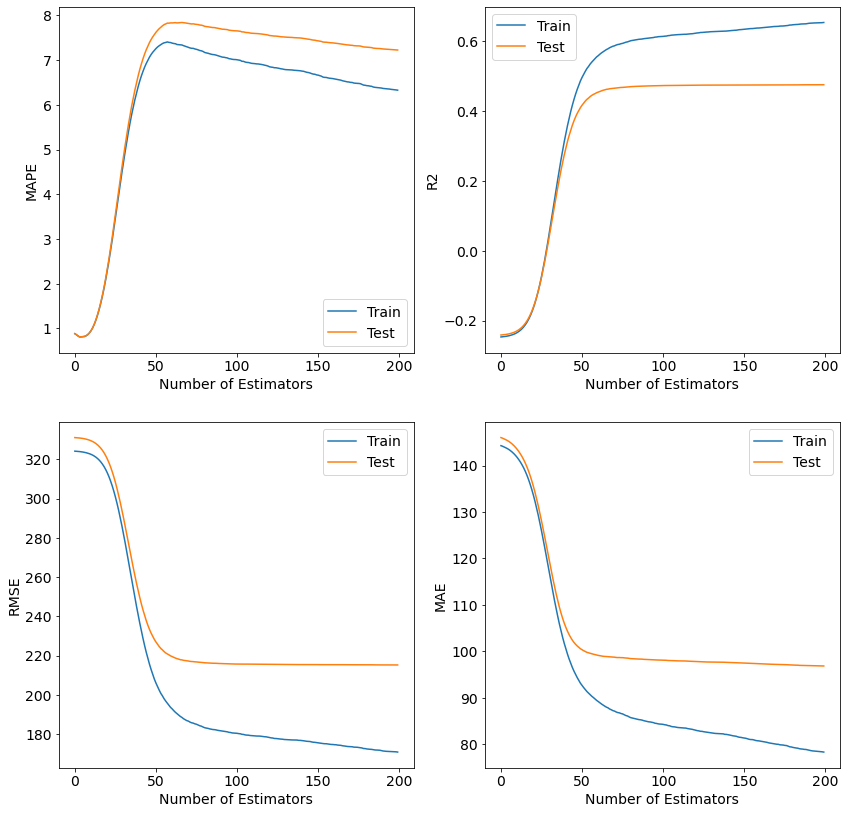

In [404]:
plt.rc('font', size=14)

# COLOR = 'white'
# plt.rcParams['text.color'] = COLOR
# plt.rcParams['axes.labelcolor'] = COLOR
# plt.rcParams['xtick.color'] = COLOR
# plt.rcParams['ytick.color'] = COLOR

fig1, axs = plt.subplots(2, 2, figsize=(14,14))

ax_list = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]

history = model.evals_result_

eval_metrics = list(model.evals_result_['validation_0'].keys())
eval_metrics.remove('tweedie-nloglik@1.5')

x_axis = range(len(history['validation_0'][eval_metrics[0]]))

for i in range(len(eval_metrics)):
    ax_list[i].plot(x_axis, history['validation_0'][eval_metrics[i]], label='Train')
    ax_list[i].plot(x_axis, history['validation_1'][eval_metrics[i]], label='Test')
    ax_list[i].set_xlabel('Number of Estimators')
    ax_list[i].set_ylabel(str(eval_metrics[i]).upper())

    l = ax_list[i].legend()
    # for text in l.get_texts():
    #     text.set_color("Black")


plt.show()


In [405]:
pred = model.predict(X_test)

In [406]:
# pred = model.predict(X_train)
mae = mean_absolute_error(y_test, pred)
print('MAE : % f' %(mae))

MAE :  96.814604


In [407]:
mse = MSE(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
print('MSE : % f' %(mse))
print("RMSE : % f" %(rmse))
print('MAE : % f' %(mae))

MSE :  46304.751713
RMSE :  215.185389
MAE :  96.814604


In [408]:
XG_REG_ERROR = pd.concat([pd.DataFrame({'Predictions':pred, 'Labels':y_test}), X_test], axis=1).sort_values('Labels')
XG_REG_ERROR['Predictions_Rounded'] = round(XG_REG_ERROR['Predictions'],0)
XG_REG_ERROR['Predictions_Bins'] = pd.qcut(XG_REG_ERROR['Predictions'], 25)
XG_REG_ERROR['Residual'] = (XG_REG_ERROR['Labels'] - XG_REG_ERROR['Predictions'])
XG_REG_ERROR['Absolute Error'] = abs(XG_REG_ERROR['Labels'] - XG_REG_ERROR['Predictions'])

In [409]:
ERROR_TABLE = pd.DataFrame(XG_REG_ERROR.groupby('Predictions_Bins')['Absolute Error'].mean()).reset_index()
ERROR_TABLE['Predictions_Bins_Lower'] = ERROR_TABLE['Predictions_Bins'].map(lambda x: str(x).split(',')[0][1:] )
ERROR_TABLE['Predictions_Bins_Upper'] = ERROR_TABLE['Predictions_Bins'].map(lambda x: str(x).split(',')[1][:-1] )
ERROR_TABLE.drop(columns='Predictions_Bins', inplace=True)
ERROR_TABLE.head()

,Absolute Error,Predictions_Bins_Lower,Predictions_Bins_Upper
0,3.336425,0.359,4.808
1,7.083139,4.808,7.482
2,11.314292,7.482,10.105
3,13.655675,10.105,12.938
4,16.487224,12.938,16.348


In [410]:
pickle.dump(ERROR_TABLE, open("/content/gdrive/My Drive/ERROR_TABLE", "wb"))

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:348: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


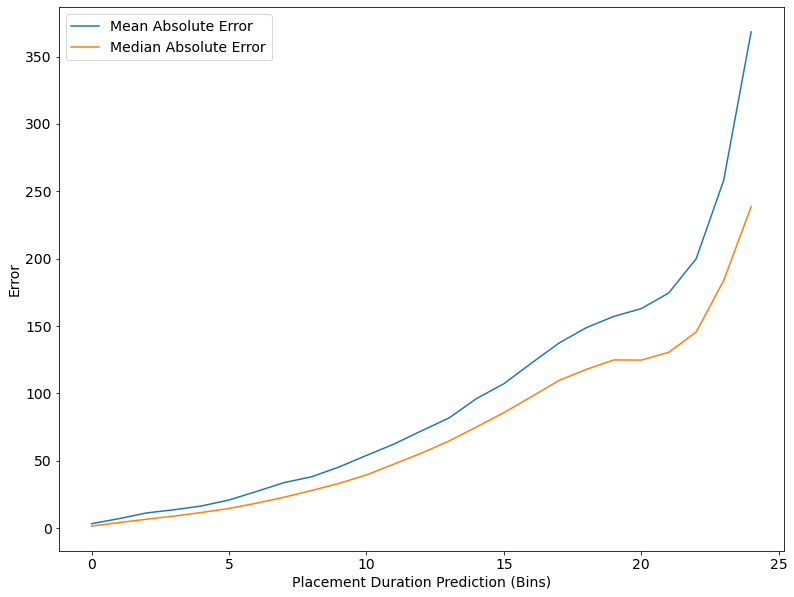

In [411]:
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR


plt.figure(figsize=(13,10))
plt.plot(XG_REG_ERROR.groupby('Predictions_Bins')['Absolute Error'].mean(), label='Mean Absolute Error')
plt.plot(XG_REG_ERROR.groupby('Predictions_Bins')['Absolute Error'].median(), label='Median Absolute Error')
plt.xlabel('Placement Duration Prediction (Bins)')
plt.ylabel('Error')
l = plt.legend()
for text in l.get_texts():
    text.set_color("Black")
plt.show()

# XGBoost - Classifier

In [412]:
y_train_clf = y_train_master['PLACEMENT_END_REASON']
y_test_clf = y_test_master['PLACEMENT_END_REASON']

In [ ]:
model_clf = XGBClassifier(objective="multi:softprob", tree_method = "gpu_hist", max_depth=10, n_estimators=200)
model_clf.fit(X_train, y_train_clf)

In [ ]:
# save model to file
pickle.dump(model_clf, open("/content/gdrive/My Drive/XGBoost_classifier", "wb"))

In [ ]:
# model_clf = pickle.load(open("/content/gdrive/My Drive/XGBoost_classifier", "rb"))

In [ ]:
# Assessing Model Accuracy When Outcomes Binned as Good or Bad
y_pred_class = model_clf.predict(X_test)

In [ ]:
y_test_clf_df = pd.DataFrame(y_test_clf).reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred_class).reset_index(drop=True).rename(columns={0:'PLACEMENT_END_REASON'})

df_list = [y_test_clf_df, y_pred_df]

for i in range(len(df_list)):
    df_list[i]['PLACEMENT_END_REASON_BIN'] = 'BAD OUTCOME'
    df_list[i].loc[df_list[i]['PLACEMENT_END_REASON'].isin(GOOD_OUTCOMES), 'PLACEMENT_END_REASON_BIN'] = 'GOOD OUTCOME'
    # df_list[i].loc[df_list[i]['PLACEMENT_END_REASON'].str.contains('APPLA'), 'PLACEMENT_END_REASON_BIN'] = 'GOOD OUTCOME'

In [ ]:
print(classification_report(y_test_clf_df['PLACEMENT_END_REASON_BIN'], y_pred_df['PLACEMENT_END_REASON_BIN']))

In [ ]:
#Creating Visuals of Individual Outcome Probabilities
y_pred_probs = model_clf.predict_proba(X_test)

In [ ]:
y_pred_probs_df = pd.DataFrame(y_pred_probs)
y_pred_probs_df.columns = model_clf.classes_

GOOD_OUTCOMES_TEST_DF = []
for i in y_pred_probs_df.columns:
    if i in GOOD_OUTCOMES:
        GOOD_OUTCOMES_TEST_DF.append(i)
TEMP_DF = y_pred_probs_df[GOOD_OUTCOMES_TEST_DF]
y_pred_probs_df['Probability of a Good Outcome'] = TEMP_DF.sum(axis=1)

add_list = ['Permanent Guardianship'
           ,'Child Ages Out'
           ,'Runaway'
           ,'Reunification'
           ,'Other'
           ,'Change Requested'
           ,'Change in EFC Supervised IL Arrangement'
           ,'Correctional Facility with Aftercare'
           ,'Entering EFC Supervised IL Arrangement'
           ,'Move Made in Accordance with Case Plan Goal'
           ,'Placement with a fit and willing Relative'
           ,'Transfer to Other Agency'
           ,'Trial Home Visit from Court-Order'
           ,'Another Planned Permanent Living Arrangement'
           ,'Voluntary Opt Out'
            ]
drop_list = [
             ['Permanent Guardianship (Includes Guardia','Permanent Guardianship to Successor Guar']
            ,['Child Ages Out (18 - 23 Years Old)','Child ages out (18 - 23 Years Old)','Child Ages Out Non-EFC','Young Adult Ages Out (EFC only)']
            ,['Runaway - Closing Case','Runaway - NOT Closing Case']
            ,['Reunification w/Parent(s) including Non-','Reunited with Removal Home Caregiver-Not']
            ,['Duplicate','Duplicate Provider Clean-up','Birthday Batch','Other']
            ,['Provider Requested Change','Child Requested Change','Parent/Relative/Guardian Requested Chang']
            ,['Change in EFC Supervised IL Arrangement/']
            ,['Child in Correctional Facility W/Afterca']
            ,['Entering EFC Supervised IL Arrangement/P']
            ,['Move Made in Accordance with Case Plan G']
            ,['Placement with a fit and willing Relativ']
            ,['Transfer to Other Agency (i.e. Out of Co']
            ,['Trial Home Visit from Court-Ordered Plcm']
            ,['APPLA (Another Planned Permanent Living ']
            ,['Voluntary Opt Out (EFC only)']
             ]


for i in range(len(add_list)):
    y_pred_probs_df[add_list[i]] = y_pred_probs_df[drop_list[i]].sum(axis=1)
    y_pred_probs_df.drop(columns=drop_list[i],inplace=True)

GOOD_OUTCOMES_V2 = ['Reunification',
              'Adoption Finalization',
              'Permanent Guardianship',
              'Placement with a fit and willing Relative',
              'Child Ages Out',
              'Adoption Placement',
              'Another Planned Permanent Living Arrangement',
              'Voluntary Opt Out',
              'Entered Military Service']

In [ ]:
plt.rc('font', size=12)

COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

fig1, ax1 = plt.subplots(figsize=(22,10))

cols = y_pred_probs_df.columns

good_cols = []
for i in range(len(cols)):
    if cols[i] in GOOD_OUTCOMES_V2:
        good_cols.append(cols[i])

not_good_cols = []
for i in range(len(cols)):
    if cols[i] not in good_cols:
        not_good_cols.append(cols[i])

df_good = y_pred_probs_df[good_cols].copy()
df_not_good = y_pred_probs_df[not_good_cols].copy()
df_not_good.drop(columns='Probability of a Good Outcome', inplace=True)

ax1.bar(df_good.columns, df_good.iloc[0])
ax1.bar(df_not_good.columns, df_not_good.iloc[0])

ax1.set_xlabel('Placement Outcomes', fontsize=14)
ax1.set_xticklabels(list(df_good.columns)+list(df_not_good.columns), rotation=45, ha='right')
ax1.set_ylabel('Probability', fontsize=14)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))


plt.show()

print('Probability of a Good Outcome:',y_pred_probs_df.iloc[0]['Probability of a Good Outcome'])


In [ ]:
#Model Performance When Training Model on All Discrete Outcomes
# print(classification_report(y_test_clf, y_pred_probs))

# Provider Lookup Table

In [ ]:
HISTORICAL = HISTORICAL.iloc[:,1:]
conn = sqlite3.connect(':memory:')
HISTORICAL.to_sql('RPH', conn, index=False)

In [ ]:
query = '''
WITH BASE AS (
    SELECT 
        PROVIDER_ID
    ,   PLACEMENT_BEGIN
    ,   PLACEMENT_END
    ,   PLACEMENT_OUTCOME
    ,   PROVIDER_NUM_PREV_PLACEMENTS
    ,   PROVIDER_NUM_PREV_PLACEMENTS_GOOD
    ,   PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL
    ,   PROVIDER_NUM_PREV_PLACEMENTS_BAD
    ,   PROVIDER_PREV_PLACEMENT_OUTCOME
    ,   PROVIDER_DAYS_SINCE_FIRST_PLACEMENT
    ,   ROW_NUMBER() OVER (PARTITION BY PROVIDER_ID ORDER BY PLACEMENT_END DESC) AS nth_placement_reverse
    FROM RPH
    
    /*NEED THE BELOW TO ENSURE THAT WE ARE ONLY LOOKING AT HISTORICAL PLACEMENTS SINCE THAT IS HOW THE MODEL IS TRAINED (WITH RESEPCT TO THESE DATA ELEMENTS)*/
    WHERE PLACEMENT_END IS NOT NULL 
)
SELECT 
    PROVIDER_ID
    ,   PLACEMENT_BEGIN AS PROVIDER_PREV_PLACEMENT_BEGIN
    ,   PLACEMENT_END AS PROVIDER_PREV_PLACEMENT_END
    ,   PROVIDER_NUM_PREV_PLACEMENTS + 1 AS PROVIDER_NUM_PREV_PLACEMENTS
    ,   CASE WHEN PLACEMENT_OUTCOME = 1 THEN PROVIDER_NUM_PREV_PLACEMENTS_GOOD + 1 ELSE PROVIDER_NUM_PREV_PLACEMENTS_GOOD END AS PROVIDER_NUM_PREV_PLACEMENTS_GOOD
    ,   CASE WHEN PLACEMENT_OUTCOME = 2 THEN PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL + 1 ELSE PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL END AS PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL
    ,   CASE WHEN PLACEMENT_OUTCOME = 3 THEN PROVIDER_NUM_PREV_PLACEMENTS_BAD + 1 ELSE PROVIDER_NUM_PREV_PLACEMENTS_BAD END AS PROVIDER_NUM_PREV_PLACEMENTS_BAD
    ,   PLACEMENT_OUTCOME AS PREV_PLACEMENT_OUTCOME
    ,   PROVIDER_DAYS_SINCE_FIRST_PLACEMENT AS PROVIDER_DAYS_SINCE_FIRST_PLACEMENT_AT_PREV_PLACEMENT
FROM BASE
WHERE nth_placement_reverse = 1
'''

CURRENT = pd.read_sql_query(query, conn)
CURRENT.to_sql('PROVIDER_HISTORICAL_FEATURES', conn, index=False, if_exists='replace')

In [ ]:
query = '''
SELECT 
    *
,   CASE WHEN PROVIDER_NUM_PREV_PLACEMENTS > 0 THEN CAST(PROVIDER_NUM_PREV_PLACEMENTS_GOOD AS FLOAT) / CAST(PROVIDER_NUM_PREV_PLACEMENTS AS FLOAT) ELSE 0 END AS PROVIDER_NUM_PREV_PLACEMENTS_GOOD_PERC
,   CASE WHEN PROVIDER_NUM_PREV_PLACEMENTS > 0 THEN CAST(PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL AS FLOAT) / CAST(PROVIDER_NUM_PREV_PLACEMENTS AS FLOAT) ELSE 0 END AS PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL_PERC
,   CASE WHEN PROVIDER_NUM_PREV_PLACEMENTS > 0 THEN CAST(PROVIDER_NUM_PREV_PLACEMENTS_BAD AS FLOAT) / CAST(PROVIDER_NUM_PREV_PLACEMENTS AS FLOAT) ELSE 0 END AS PROVIDER_NUM_PREV_PLACEMENTS_BAD_PERC
FROM PROVIDER_HISTORICAL_FEATURES
'''

CURRENT = pd.read_sql_query(query, conn)

In [ ]:
PROVIDER_FEATURES = one_hot(CURRENT, 'PREV_PLACEMENT_OUTCOME', dummy_na=False)

PROVIDER_FEATURES['PROVIDER_PREV_PLACEMENT_OUTCOME_1.0'] = PROVIDER_FEATURES['PREV_PLACEMENT_OUTCOME_1']
PROVIDER_FEATURES['PROVIDER_PREV_PLACEMENT_OUTCOME_2.0'] = PROVIDER_FEATURES['PREV_PLACEMENT_OUTCOME_2']
PROVIDER_FEATURES['PROVIDER_PREV_PLACEMENT_OUTCOME_3.0'] = PROVIDER_FEATURES['PREV_PLACEMENT_OUTCOME_3']

PROVIDER_FEATURES['LATEST_PLACEMENT_IN_DATASET'] = PROVIDER_FEATURES['PROVIDER_PREV_PLACEMENT_END'].max()
PROVIDER_FEATURES['DAY_INCREMENT'] = (pd.to_datetime(PROVIDER_FEATURES['LATEST_PLACEMENT_IN_DATASET']) - pd.to_datetime(PROVIDER_FEATURES['PROVIDER_PREV_PLACEMENT_END'])).dt.days
PROVIDER_FEATURES['PROVIDER_DAYS_SINCE_FIRST_PLACEMENT'] = PROVIDER_FEATURES['PROVIDER_DAYS_SINCE_FIRST_PLACEMENT_AT_PREV_PLACEMENT'] + PROVIDER_FEATURES['DAY_INCREMENT']



In [ ]:
AFCARS_PROVIDER_LU = PLACEMENT_W_AFCARS.copy()
AFCARS_PROVIDER_LU['ROW_NUM'] = AFCARS_PROVIDER_LU.sort_values('PLACEMENT_BEGIN_DATE', ascending=False).groupby(['PROVIDER_ID']).cumcount()+1
AFCARS_PROVIDER_LU = AFCARS_PROVIDER_LU[AFCARS_PROVIDER_LU['ROW_NUM'] == 1][['PROVIDER_ID','RF1AMAKN'
,'RF1ASIAN'
,'RF1BLKAA'
,'RF1NHOPI'
,'RF1WHITE'
,'RF1UTOD'
,'HOFCCTK1'

,'PLACEMENT_(NULL)'
,'PLACEMENT_FOSTER_FAMILY_HOME_(NON-RELATIVE)'
,'PLACEMENT_FOSTER_FAMILY_HOME_(RELATIVE)'
,'PLACEMENT_GROUP_HOME'
,'PLACEMENT_INSTITUTION'
,'PLACEMENT_PRE-ADOPTIVE_HOME'
,'PLACEMENT_RUNAWAY'
,'PLACEMENT_SUPERVISED_INDEPENDENT_LIVING'
,'PLACEMENT_TRIAL_HOME_VISIT'

,'FCCTK1YR']]

AFCARS_PROVIDER_LU['FOSTER_AGE'] = pd.to_datetime(PROVIDER_FEATURES['PROVIDER_PREV_PLACEMENT_END'].max()).year - AFCARS_PROVIDER_LU['FCCTK1YR']

In [ ]:
AFCARS_PROVIDER_LU['PROVIDER_ID'] = AFCARS_PROVIDER_LU['PROVIDER_ID'].astype(int)

In [ ]:
PROVIDER_FEATURES_LU = pd.merge(AFCARS_PROVIDER_LU, PROVIDER_FEATURES, on='PROVIDER_ID', how='left')

In [ ]:
PROVIDER_FEATURES_LU.drop(columns=['PREV_PLACEMENT_OUTCOME_1','PREV_PLACEMENT_OUTCOME_2','PREV_PLACEMENT_OUTCOME_3','PROVIDER_DAYS_SINCE_FIRST_PLACEMENT_AT_PREV_PLACEMENT',
                                'PROVIDER_PREV_PLACEMENT_BEGIN','PROVIDER_PREV_PLACEMENT_END','LATEST_PLACEMENT_IN_DATASET','DAY_INCREMENT','FCCTK1YR','PREV_PLACEMENT_OUTCOME'], inplace=True)

In [ ]:
# save to file
pickle.dump(PROVIDER_FEATURES_LU, open("/content/gdrive/My Drive/PROVIDER_FEATURES_LU", "wb"))

# UI

In [ ]:
CHILD_FEATURES = [
                                #  'AFCARS_ID'
                                #  ,'REMOVAL_DATE_CLEAN'
                                #  ,'PLACEMENT_BEGIN_DATE_CLEAN'
                                #  ,'PLACEMENT_END_DATE_CLEAN'
                                #  ,'DISCHARGE_DATE_CLEAN'
                                #  ,'PLACEMENT_SETTING' #One-Hot Encode

                                  #REASONS FOR ENTERING FOSTER CARE SYSTEM
                                 'PHYSICAL_ABUSE'
                                 ,'SEXUAL_ABUSE'                                                           
                                 ,'EMOTIONAL_ABUSE_NEGLECT'
                                 ,'ALCOHOL_ABUSE_CHILD'
                                 ,'DRUG_ABUSE_CHILD'
                                 ,'ALCOHOL_ABUSE_PARENT'
                                 ,'DRUG_ABUSE_PARENT'
                                 ,'PHYSICAL_NEGLECT'
                                 ,'DOMESTIC_VIOLENCE'
                                 ,'INADEQUATE_HOUSING'
                                 ,'CHILD_BEHAVIOR_PROBLEM'
                                 ,'CHILD_DISABILITY'
                                 ,'INCARCERATION_OF_PARENT'
                                 ,'DEATH_OF_PARENT'
                                 ,'CAREGIVER_INABILITY_TO_COPE'
                                 ,'ABANDONMENT'
                                 ,'TRANSITION_TO_INDEPENDENCE'
                                 ,'INADEQUATE_SUPERVISION'
                                 ,'PROSPECTIVE_EMOTIONAL_ABUSE_NEGLECT'
                                 ,'PROSPECTIVE_MEDICAL_NEGLECT'
                                 ,'PROSPECTIVE_PHYSICAL_ABUSE'
                                 ,'PROSPECTIVE_PHYSICAL_NEGLECT'
                                 ,'PROSPECTIVE_SEXUAL_ABUSE'
                                 ,'RELINQUISHMENT'
                                 ,'REQUEST_FOR_SERVICE'
                                 ,'ADOPTION_DISSOLUTION'
                                 ,'MEDICAL_NEGLECT'
                                 ,'CSEC'
                                 ,'LABOR_TRAFFICKING'
                                 ,'SEXUAL_ABUSE_SEXUAL_EXPLOITATION'   
            

                                # Demograhics
                                 ,'RACE_WHITE'
                                 ,'RACE_BLACK'
                                 ,'RACE_ASIAN'
                                 ,'RACE_UNKNOWN'
                                 ,'RACE_HAWAIIAN'
                                 ,'RACE_AMERICAN_INDIAN'
                                 ,'RACE_MULTI_RCL'
                                 ,'HISPANIC'

                                 ,'AGE_AT_PLACEMENT_BEGIN'
                                 ,'NEW_REMOVAL'
                                 

                                #  ,REMOVAL_LENGTH #Need to make reflective as of placement begin date   
                                #  ,PLACEMENT_NUMBER #Need to apply after using James's flattened version

                                 #Children and Foster Home Profiling                            
                                 ,'CHILD_NUM_PREV_PLACEMENTS'
                                 ,'CHILD_NUM_PREV_PLACEMENTS_GOOD'
                                 ,'CHILD_NUM_PREV_PLACEMENTS_NEUTRAL'
                                 ,'CHILD_NUM_PREV_PLACEMENTS_BAD'

                                 ,'CHILD_PREV_PLACEMENT_OUTCOME_1.0'
                                 ,'CHILD_PREV_PLACEMENT_OUTCOME_2.0'	
                                 ,'CHILD_PREV_PLACEMENT_OUTCOME_3.0'	
                                 ,'CHILD_PREV_PLACEMENT_OUTCOME_nan'	

                                 ,'CHILD_DAYS_SINCE_FIRST_PLACEMENT'

                                 ,'CHILD_NUM_PREV_PLACEMENTS_GOOD_PERC'
                                 ,'CHILD_NUM_PREV_PLACEMENTS_NEUTRAL_PERC'
                                 ,'CHILD_NUM_PREV_PLACEMENTS_BAD_PERC'

                                #  ,'MOVE_MILES'
                                #  ,'ROOMMATE_COUNT'


                                #AFCARS FEATURES
                                ,'IVEFC'
                                ,'IVEAA'
                                ,'IVAAFDC'
                                ,'IVDCHSUP'
                                ,'XIXMEDCD'
                                ,'SSIOTHER'
                                ,'NOA'
                                ,'FCMNTPAY'  

                                ,'CLINDIS'
                                ,'MR'
                                ,'VISHEAR'
                                ,'PHYDIS'
                                ,'EMOTDIST'
                                ,'OTHERMED'

                                ,'CASEGOAL_1'
                                ,'CASEGOAL_2'
                                ,'CASEGOAL_3'
                                ,'CASEGOAL_4'
                                ,'CASEGOAL_5'
                                ,'CASEGOAL_6'
                                ,'CASEGOAL_7'
                                ,'CASEGOAL_99'

                                ,'ISWAITING'

                                ,'EVERADPT_1.0'
                                ,'EVERADPT_2.0'
                                # ,'EVERADPT_3.0'

                                ,'AGEADOPT_0.0'
                                ,'AGEADOPT_1.0'
                                ,'AGEADOPT_2.0'
                                ,'AGEADOPT_3.0'
                                ,'AGEADOPT_4.0'
                                # ,'AGEADOPT_5.0'
                                # ,'AGEADOPT_nan'

                                ,'CTKFAMST_1.0'
                                ,'CTKFAMST_2.0'
                                ,'CTKFAMST_3.0'
                                ,'CTKFAMST_4.0'
                                # ,'CTKFAMST_5.0'

       
                                ,'CARETAKER_AGE'


                                 ]


In [ ]:
FOSTER_FEATURES = [                            
                                 'PROVIDER_NUM_PREV_PLACEMENTS_GOOD_PERC'
                                 ,'PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL_PERC'
                                 ,'PROVIDER_NUM_PREV_PLACEMENTS_BAD_PERC'

                                 ,'PROVIDER_DAYS_SINCE_FIRST_PLACEMENT'


                                 ,'PROVIDER_NUM_PREV_PLACEMENTS'
                                 ,'PROVIDER_NUM_PREV_PLACEMENTS_GOOD'
                                 ,'PROVIDER_NUM_PREV_PLACEMENTS_NEUTRAL'
                                 ,'PROVIDER_NUM_PREV_PLACEMENTS_BAD'

                                 ,'PROVIDER_PREV_PLACEMENT_OUTCOME_1.0'
                                 ,'PROVIDER_PREV_PLACEMENT_OUTCOME_2.0'
                                 ,'PROVIDER_PREV_PLACEMENT_OUTCOME_3.0'
                                 

                                #Placement Details
                                 ,'PLACEMENT_(NULL)'
                                 ,'PLACEMENT_FOSTER_FAMILY_HOME_(NON-RELATIVE)'
                                 ,'PLACEMENT_FOSTER_FAMILY_HOME_(RELATIVE)'
                                 ,'PLACEMENT_GROUP_HOME'
                                 ,'PLACEMENT_INSTITUTION'
                                 ,'PLACEMENT_PRE-ADOPTIVE_HOME'
                                 ,'PLACEMENT_RUNAWAY'
                                 ,'PLACEMENT_SUPERVISED_INDEPENDENT_LIVING'
                                 ,'PLACEMENT_TRIAL_HOME_VISIT'
                               
                                ,'RF1AMAKN'
                                ,'RF1ASIAN'
                                ,'RF1BLKAA'
                                ,'RF1NHOPI'
                                ,'RF1WHITE'
                                ,'RF1UTOD'
                                ,'HOFCCTK1'

                                ,'FOSTER_AGE'
]

In [ ]:
TEST_CHILD = MODEL_DF.sample(5)[CHILD_FEATURES].reset_index(drop=True)

In [ ]:
TEST_FOSTER = PROVIDER_FEATURES_LU.sample(5)[FOSTER_FEATURES].reset_index(drop=True)

In [ ]:
NEW_RECORDS = pd.concat([TEST_CHILD, TEST_FOSTER], axis =1)
NEW_RECORDS

In [382]:
model = pickle.load(open("/content/gdrive/My Drive/XGBoost_regressor", "rb"))

In [342]:
ERROR_TABLE = pickle.load(open("/content/gdrive/My Drive/ERROR_TABLE", "rb"))

In [343]:
model_clf = pickle.load(open("/content/gdrive/My Drive/XGBoost_classifier", "rb"))

In [ ]:
def get_duration(model, error_table, records):
    predicted_duration = pd.DataFrame(model.predict(records)).rename(columns={0:'Predicted Duration'})
    # predicted_duration = pd.merge(predicted_duration, error_table, on='key')[list(predicted_duration.columns)+list(error_table.columns)]
    predicted_duration = predicted_duration.assign(foo=1).merge(error_table.assign(foo=1)).drop('foo', 1)
    predicted_duration = predicted_duration.apply(pd.to_numeric)
    predicted_duration = predicted_duration[(predicted_duration['Predicted Duration'] >= predicted_duration['Predictions_Bins_Lower']) &
                                            (predicted_duration['Predicted Duration'] < predicted_duration['Predictions_Bins_Upper'])][['Predicted Duration', 'Absolute Error']].reset_index(drop=True)
    return predicted_duration

In [ ]:
def get_probability_of_good_outcome(model_clf, records):
    y_pred_probs = model_clf.predict_proba(records)
    y_pred_probs_df = pd.DataFrame(y_pred_probs)
    y_pred_probs_df.columns = model_clf.classes_

    GOOD_OUTCOMES = ['Reunification w/Parent(s) including Non-',
              'Adoption Finalization',
              'Permanent Guardianship (Includes Guardia',
              'Placement with a fit and willing Relativ',
              'Child ages out (18 - 23 Years Old)',
              'Adoption Placement',
              'Reunited with Removal Home Caregiver-Not',
              'APPLA (Another Planned Permanent Living',
              'Voluntary Opt Out (EFC only)',
              'Child Ages Out Non-EFC',
              'Young Adult Ages Out (EFC only)',
              'Permanent Guardianship to Successor Guar',
              'Child Ages Out (18 - 23 Years Old)',
              'Entered Military Service']

    GOOD_OUTCOMES_TEST_DF = []
    for i in y_pred_probs_df.columns:
        if i in GOOD_OUTCOMES:
            GOOD_OUTCOMES_TEST_DF.append(i)
    TEMP_DF = y_pred_probs_df[GOOD_OUTCOMES_TEST_DF]
    return pd.DataFrame(TEMP_DF.sum(axis=1)).reset_index(drop=True).rename(columns={0:'Probability of Good Outcome'})

In [ ]:
def get_probability_distribution(record):
    y_pred_probs = model_clf.predict_proba(record)
    y_pred_probs_df = pd.DataFrame(y_pred_probs)
    y_pred_probs_df.columns = model_clf.classes_

    GOOD_OUTCOMES = ['Reunification w/Parent(s) including Non-',
              'Adoption Finalization',
              'Permanent Guardianship (Includes Guardia',
              'Placement with a fit and willing Relativ',
              'Child ages out (18 - 23 Years Old)',
              'Adoption Placement',
              'Reunited with Removal Home Caregiver-Not',
              'APPLA (Another Planned Permanent Living',
              'Voluntary Opt Out (EFC only)',
              'Child Ages Out Non-EFC',
              'Young Adult Ages Out (EFC only)',
              'Permanent Guardianship to Successor Guar',
              'Child Ages Out (18 - 23 Years Old)',
              'Entered Military Service']

    GOOD_OUTCOMES_TEST_DF = []
    for i in y_pred_probs_df.columns:
        if i in GOOD_OUTCOMES:
            GOOD_OUTCOMES_TEST_DF.append(i)
    TEMP_DF = y_pred_probs_df[GOOD_OUTCOMES_TEST_DF]
    y_pred_probs_df['Probability of a Good Outcome'] = TEMP_DF.sum(axis=1)

    add_list = ['Permanent Guardianship'
            ,'Child Ages Out'
            ,'Runaway'
            ,'Reunification'
            ,'Other'
            ,'Change Requested'
            ,'Change in EFC Supervised IL Arrangement'
            ,'Correctional Facility with Aftercare'
            ,'Entering EFC Supervised IL Arrangement'
            ,'Move Made in Accordance with Case Plan Goal'
            ,'Placement with a fit and willing Relative'
            ,'Transfer to Other Agency'
            ,'Trial Home Visit from Court-Order'
            ,'Another Planned Permanent Living Arrangement'
            ,'Voluntary Opt Out'
                ]
    drop_list = [
                ['Permanent Guardianship (Includes Guardia','Permanent Guardianship to Successor Guar']
                ,['Child Ages Out (18 - 23 Years Old)','Child ages out (18 - 23 Years Old)','Child Ages Out Non-EFC','Young Adult Ages Out (EFC only)']
                ,['Runaway - Closing Case','Runaway - NOT Closing Case']
                ,['Reunification w/Parent(s) including Non-','Reunited with Removal Home Caregiver-Not']
                ,['Duplicate','Duplicate Provider Clean-up','Birthday Batch','Other']
                ,['Provider Requested Change','Child Requested Change','Parent/Relative/Guardian Requested Chang']
                ,['Change in EFC Supervised IL Arrangement/']
                ,['Child in Correctional Facility W/Afterca']
                ,['Entering EFC Supervised IL Arrangement/P']
                ,['Move Made in Accordance with Case Plan G']
                ,['Placement with a fit and willing Relativ']
                ,['Transfer to Other Agency (i.e. Out of Co']
                ,['Trial Home Visit from Court-Ordered Plcm']
                ,['APPLA (Another Planned Permanent Living ']
                ,['Voluntary Opt Out (EFC only)']
                ]


    for i in range(len(add_list)):
        y_pred_probs_df[add_list[i]] = y_pred_probs_df[drop_list[i]].sum(axis=1)
        y_pred_probs_df.drop(columns=drop_list[i],inplace=True)

    GOOD_OUTCOMES_V2 = ['Reunification',
                'Adoption Finalization',
                'Permanent Guardianship',
                'Placement with a fit and willing Relative',
                'Child Ages Out',
                'Adoption Placement',
                'Another Planned Permanent Living Arrangement',
                'Voluntary Opt Out',
                'Entered Military Service']

    plt.rc('font', size=12)

    COLOR = 'black'
    plt.rcParams['text.color'] = COLOR
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR

    fig1, ax1 = plt.subplots(figsize=(22,10))

    cols = y_pred_probs_df.columns

    good_cols = []
    for i in range(len(cols)):
        if cols[i] in GOOD_OUTCOMES_V2:
            good_cols.append(cols[i])

    not_good_cols = []
    for i in range(len(cols)):
        if cols[i] not in good_cols:
            not_good_cols.append(cols[i])

    df_good = y_pred_probs_df[good_cols].copy()
    df_not_good = y_pred_probs_df[not_good_cols].copy()
    df_not_good.drop(columns='Probability of a Good Outcome', inplace=True)

    ax1.bar(df_good.columns, df_good.iloc[0])
    ax1.bar(df_not_good.columns, df_not_good.iloc[0])

    ax1.set_xlabel('Placement Outcomes', fontsize=14)
    ax1.set_xticklabels(list(df_good.columns)+list(df_not_good.columns), rotation=45, ha='right')
    ax1.set_ylabel('Probability', fontsize=14)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


    plt.show()

    # print('Probability of a Good Outcome:',y_pred_probs_df.iloc[0]['Probability of a Good Outcome'])


In [ ]:
test = get_duration(model, ERROR_TABLE, NEW_RECORDS.iloc[0:5])
test

In [183]:
get_probability_of_good_outcome(model_clf, X_test.iloc[0:5])

,Probability of Good Outcome
0,0.005652
1,0.011750
2,0.405603
3,0.010962
4,0.030896


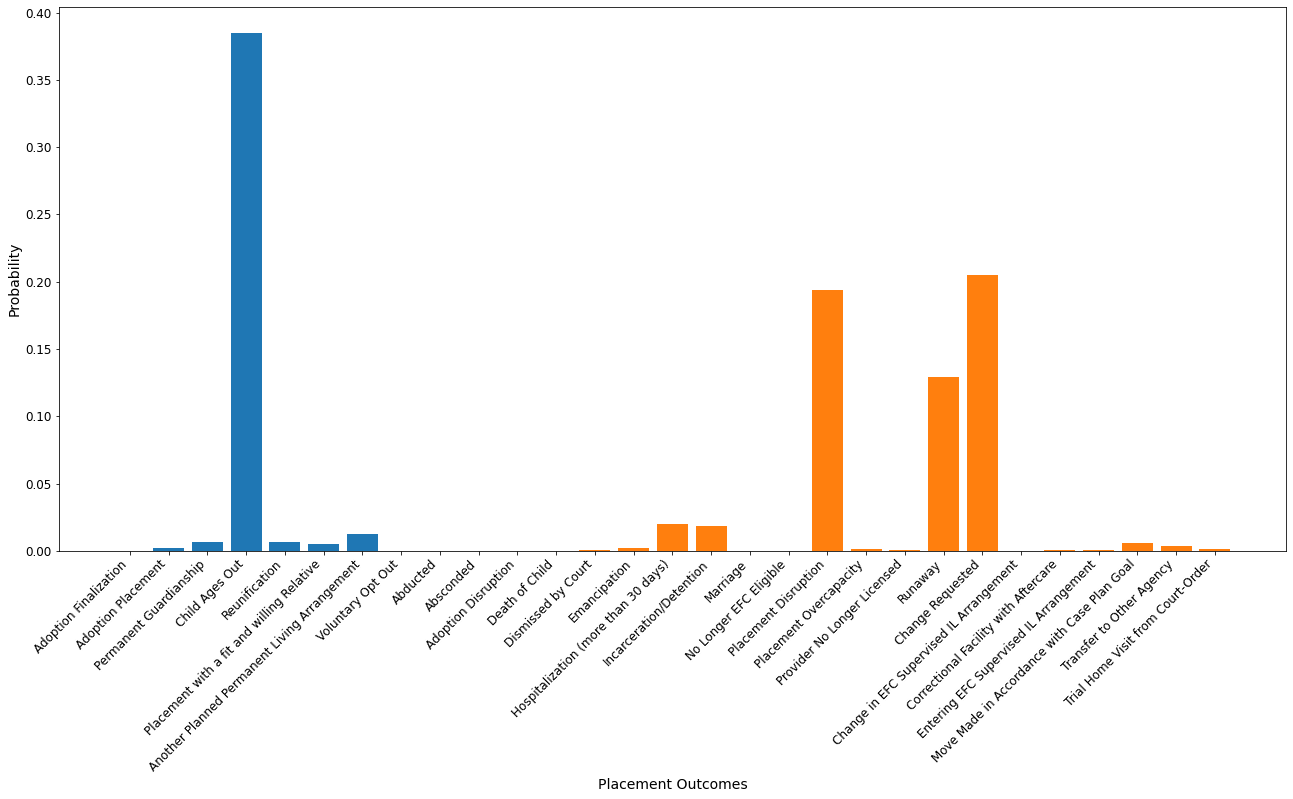

In [204]:
get_probability_distribution(pd.DataFrame(X_test.iloc[2]).T)